In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir /content/data

!cp -r /content/drive/MyDrive/dataset/PartVisionTask/* /content/data

In [ ]:
import sys
import glob
import cv2
import numpy as np
import os

from shutil import copytree
from shutil import rmtree

categories=['iranKhodro_dena', 'kia_cerato', 'mazda_3', 'peugeot_206', 'saipa_saina']
default_path="/content/data"
ttv = ['train', 'test', 'valid']

for i in ttv:
  os.mkdir("/content/data/{}".format(i))

whole_images=[]
for i in categories:
  images_path=os.path.join(default_path, i)
  images = glob.glob(images_path + "/*.jpg")
  images.sort()
  whole_images.append(images)

for i in ttv:
  for j in categories:
    os.mkdir("/content/data/{}/{}".format(i, j))

for i in range(len(ttv)):
  for j in range(len(categories)):
    if i ==2:
      count=len(whole_images[j][int(len(whole_images[j])*0.1)+5:])+5
      for k in range(int(len(whole_images[j])*0.1)):
        img=cv2.imread(whole_images[j][count+k])
        img_name=os.path.split(whole_images[j][count+k])[1]
        cv2.imwrite("/content/data/{}/{}/{}".format(ttv[i], categories[j], img_name), img)
        os.remove(whole_images[j][count+k])
    elif i ==1:
      count=len(whole_images[j][int(len(whole_images[j])*0.1)+5:])
      for k in range(5):
        img=cv2.imread(whole_images[j][count+k])
        img_name=os.path.split(whole_images[j][count+k])[1]
        cv2.imwrite("/content/data/{}/{}/{}".format(ttv[i], categories[j], img_name), img)
        os.remove(whole_images[j][count+k])
    else:
      for k in range(len(whole_images[j][int(len(whole_images[j])*0.1)+5:])):
        img=cv2.imread(whole_images[j][k])
        img_name=os.path.split(whole_images[j][k])[1]
        cv2.imwrite("/content/data/{}/{}/{}".format(ttv[i], categories[j], img_name), img)    
        os.remove(whole_images[j][k])
		
for i in categories:
    rmtree("/content/data/{}".format(i))

In [ ]:
import pickle
import math, re, os
from os import path

import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import random
import shutil
import pathlib

EPOCHS = 150
BATCH_SIZE = 20

BASE_FOLDER = '/content/data/'

In [ ]:
def create_cnn_model():
	from tensorflow.keras.optimizers import Adamax
	num_classes = 5

	model = tf.keras.models.Sequential([
			tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
			tf.keras.layers.MaxPooling2D(2, 2),
			tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
			tf.keras.layers.MaxPooling2D(2, 2),
			tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
			tf.keras.layers.MaxPooling2D(2, 2),
			tf.keras.layers.Conv2D(120, (3, 3), activation='relu'),
			tf.keras.layers.MaxPooling2D(2, 2),
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(105, activation='relu'),
			tf.keras.layers.Dense(5, activation='softmax')
	])


	model.compile(optimizer=Adamax(lr=1e-3,beta_1=0.9, beta_2=0.999, epsilon=1e-07) , loss='categorical_crossentropy', metrics=['accuracy'])

	print(model.summary())
	return model

In [ ]:
def create_callbacks():
    early_stopping = EarlyStopping(patience=35, monitor='val_loss', verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.001,
                                  patience=25, mode='min',
                                  verbose=1)

    model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                       filepath='/content/drive/MyDrive/models/IranianCars/my_own_model.h5',
                                       save_best_only=True,
                                       verbose=1)

    callbacks = [
        early_stopping,
        reduce_lr,
        model_checkpoint
    ]

    return callbacks

In [ ]:
def train_model_naive_split():

  train_datagen = ImageDataGenerator(
        rescale=1./255 ,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
      )

  train_iterator = train_datagen.flow_from_directory('/content/data/train/',
                                                   target_size=(224, 224),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical')
  validation_datagen = ImageDataGenerator(
      rescale=1./255 ,
      rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
      )

  validation_iterator = validation_datagen.flow_from_directory('/content/data/valid/',
                                                             target_size=(224, 224),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical')

  model = create_cnn_model()

  history =  model.fit(
          train_iterator,  
          epochs=EPOCHS,
          validation_data=validation_iterator,
          verbose=2,
          callbacks=create_callbacks()
        )

  return history

In [ ]:
history = train_model_naive_split()

Found 1872 images belonging to 5 classes.
Found 209 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 120)       6

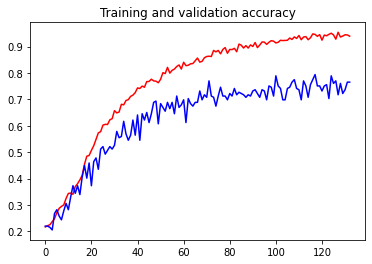

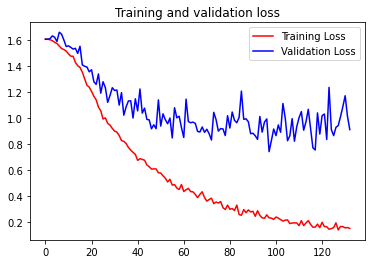

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def load_and_predict(model):
  
  test_generator = ImageDataGenerator(rescale=1. / 255)

  test_iterator = test_generator.flow_from_directory(
        '/content/data/test/',
        target_size=(224, 224),
        shuffle=False,
        class_mode='categorical',
        batch_size=1) 

  ids = []
  for filename in test_iterator.filenames:
    print(filename)
    ids.append(filename)

  predict_result = model.predict(test_iterator, steps=len(test_iterator.filenames))
  predictions = []
  for index, prediction in enumerate(predict_result):
    classes = np.argmax(prediction)
    predictions.append([ids[index], classes])
  predictions.sort()

  return predictions

In [ ]:
def store_prediction():
  model = keras.models.load_model('/content/drive/MyDrive/models/IranianCars/my_own_model.h5', compile = True)

  predictions = load_and_predict(model)

  df = pd.DataFrame(data=predictions, columns=['image_id', 'label'])
  df = df.set_index(['image_id'])

  print(df.head())
  print('Writing submission')
  df.to_csv('/content/results.csv')

In [ ]:
store_prediction()

Found 25 images belonging to 5 classes.
iranKhodro_dena/58.jpg
iranKhodro_dena/59.jpg
iranKhodro_dena/6.jpg
iranKhodro_dena/60.jpg
iranKhodro_dena/61.jpg
kia_cerato/59.jpg
kia_cerato/6.jpg
kia_cerato/60.jpg
kia_cerato/61.jpg
kia_cerato/62.jpg
mazda_3/58.jpg
mazda_3/59.jpg
mazda_3/6.jpg
mazda_3/60.jpg
mazda_3/61.jpg
peugeot_206/58.jpg
peugeot_206/59.jpg
peugeot_206/6.jpg
peugeot_206/60.jpg
peugeot_206/61.jpg
saipa_saina/53.jpg
saipa_saina/54.jpg
saipa_saina/55.jpg
saipa_saina/56.jpg
saipa_saina/57.jpg
                        label
image_id                     
iranKhodro_dena/58.jpg      0
iranKhodro_dena/59.jpg      0
iranKhodro_dena/6.jpg       0
iranKhodro_dena/60.jpg      1
iranKhodro_dena/61.jpg      0
Writing submission


In [ ]:
!cat /content/results.csv

image_id,label
iranKhodro_dena/58.jpg,0
iranKhodro_dena/59.jpg,0
iranKhodro_dena/6.jpg,0
iranKhodro_dena/60.jpg,1
iranKhodro_dena/61.jpg,0
kia_cerato/59.jpg,1
kia_cerato/6.jpg,2
kia_cerato/60.jpg,1
kia_cerato/61.jpg,1
kia_cerato/62.jpg,1
mazda_3/58.jpg,2
mazda_3/59.jpg,2
mazda_3/6.jpg,2
mazda_3/60.jpg,2
mazda_3/61.jpg,2
peugeot_206/58.jpg,3
peugeot_206/59.jpg,3
peugeot_206/6.jpg,3
peugeot_206/60.jpg,3
peugeot_206/61.jpg,3
saipa_saina/53.jpg,4
saipa_saina/54.jpg,4
saipa_saina/55.jpg,4
saipa_saina/56.jpg,4
saipa_saina/57.jpg,4
